# 개인 프로젝트 : 구매 예측 프로젝트
    - 특정 시간대 별 구매 활성 여부를 예측

## 1. 데이터 로드

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("241218_analyze_project").getOrCreate()

24/12/20 09:31:07 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [2]:
df = spark.read.format("csv")\
    .option("header", 'true')\
    .option('inferSchema', 'true')\
    .option('encoding', 'CP949')\
    .load('data/거주지(소비자)기준 행정동별 상품판매.csv')

In [3]:
df.show(3)

+----------------+---------------------+-----------------------+----------------+------------------+-------------------+--------------------+------------------+------------------+
|기준년월(STD_YM)|행정동코드(ADSTRD_CD)|통계청상품코드(STAT_CD)|성별코드(SEX_CD)|연령대코드(AGE_CD)|시간대코드(TIME_CD)|구매_고객수(ACC_CNT)|구매건수(PURH_CNT)|구매금액(PURH_AMT)|
+----------------+---------------------+-----------------------+----------------+------------------+-------------------+--------------------+------------------+------------------+
|          201907|             11200720|                      E|               1|                 4|                  5|                   5|                16|            436000|
|          201809|             11140635|                      E|               1|                 7|                  4|                 179|                18|            110000|
|          201805|             11380632|                      J|               2|                 3|                  5|                   5|  

In [4]:
df.printSchema()

root
 |-- 기준년월(STD_YM): integer (nullable = true)
 |-- 행정동코드(ADSTRD_CD): integer (nullable = true)
 |-- 통계청상품코드(STAT_CD): string (nullable = true)
 |-- 성별코드(SEX_CD): integer (nullable = true)
 |-- 연령대코드(AGE_CD): integer (nullable = true)
 |-- 시간대코드(TIME_CD): integer (nullable = true)
 |-- 구매_고객수(ACC_CNT): integer (nullable = true)
 |-- 구매건수(PURH_CNT): integer (nullable = true)
 |-- 구매금액(PURH_AMT): integer (nullable = true)



In [5]:
df.count()

500

## 2. 데이터 전처리

### 1) 결측치 확인

In [6]:
from pyspark.sql.functions import col, isnan, when, count


df.select(
    [count(when(col(c).isNull() | isnan(col(c)), c)).alias(c) for c in df.columns]
).show()

+----------------+---------------------+-----------------------+----------------+------------------+-------------------+--------------------+------------------+------------------+
|기준년월(STD_YM)|행정동코드(ADSTRD_CD)|통계청상품코드(STAT_CD)|성별코드(SEX_CD)|연령대코드(AGE_CD)|시간대코드(TIME_CD)|구매_고객수(ACC_CNT)|구매건수(PURH_CNT)|구매금액(PURH_AMT)|
+----------------+---------------------+-----------------------+----------------+------------------+-------------------+--------------------+------------------+------------------+
|               0|                    0|                      0|               0|                 0|                  0|                   0|                 0|                 0|
+----------------+---------------------+-----------------------+----------------+------------------+-------------------+--------------------+------------------+------------------+



### 2) 데이터 열 이름 변경

In [7]:
# 열 이름에서 영어 코드만 추출
new_columns = [col.split("(")[-1].replace(")", "") for col in df.columns]  # 영어 코드만 추출
df = df.toDF(*new_columns)  # 새 열 이름 적용

# 결과 열 이름 확인
print(df.columns)

['STD_YM', 'ADSTRD_CD', 'STAT_CD', 'SEX_CD', 'AGE_CD', 'TIME_CD', 'ACC_CNT', 'PURH_CNT', 'PURH_AMT']


### 3) 분석에 활용할 데이터 선택

In [12]:
a_df = df.select("STD_YM", "ADSTRD_CD", "STAT_CD", "SEX_CD", "AGE_CD", "TIME_CD", "ACC_CNT", "PURH_CNT")

In [13]:
a_df.show(3)

+------+---------+-------+------+------+-------+-------+--------+
|STD_YM|ADSTRD_CD|STAT_CD|SEX_CD|AGE_CD|TIME_CD|ACC_CNT|PURH_CNT|
+------+---------+-------+------+------+-------+-------+--------+
|201907| 11200720|      E|     1|     4|      5|      5|      16|
|201809| 11140635|      E|     1|     7|      4|    179|      18|
|201805| 11380632|      J|     2|     3|      5|      5|       2|
+------+---------+-------+------+------+-------+-------+--------+
only showing top 3 rows



## 3. 데이터 기초 분석

### 1) 기술통계치 확인

In [14]:
a_df.describe().show()

+-------+------------------+------------------+-------+-------------------+------------------+------------------+------------------+-----------------+
|summary|            STD_YM|         ADSTRD_CD|STAT_CD|             SEX_CD|            AGE_CD|           TIME_CD|           ACC_CNT|         PURH_CNT|
+-------+------------------+------------------+-------+-------------------+------------------+------------------+------------------+-----------------+
|  count|               500|               500|    500|                500|               500|               500|               500|              500|
|   mean|        201853.004|    1.1435948382E7|   null|              1.526|             4.074|             3.932|            49.024|            99.12|
| stddev|50.132329738103536|185625.45644591315|   null|0.49982361618333826|1.6067630113832891|1.4026085060495268|178.35805171964188|373.8095514583904|
|    min|            201801|          11110530|      A|                  1|                 1|

In [15]:
a_df.groupBy("ADSTRD_CD").count().orderBy("count", ascending=False).show()

[Stage 13:========================================>             (150 + 2) / 200]

+---------+-----+
|ADSTRD_CD|count|
+---------+-----+
| 11680690|    6|
| 11410565|    6|
| 11230705|    5|
| 11710647|    5|
| 11650530|    5|
| 11380552|    4|
| 11200560|    4|
| 11560540|    4|
| 11590680|    4|
| 11410655|    4|
| 11380530|    4|
| 11710642|    4|
| 11710650|    4|
| 11530540|    4|
| 11710610|    3|
| 11410710|    3|
| 11470600|    3|
| 11530760|    3|
| 11680521|    3|
| 11680700|    3|
+---------+-----+
only showing top 20 rows



In [16]:
a_df.groupBy("ADSTRD_CD").count().orderBy("count", ascending=False).count()

294

In [17]:
a_df.groupBy("STD_YM").count().orderBy("count", ascending=False).show()

[Stage 18:======================================>               (144 + 2) / 200]

+------+-----+
|STD_YM|count|
+------+-----+
|201803|   32|
|201810|   29|
|201802|   26|
|201805|   25|
|201812|   23|
|201908|   23|
|201907|   23|
|201910|   22|
|201901|   21|
|201904|   21|
|201801|   21|
|201806|   21|
|201905|   20|
|201809|   20|
|201808|   20|
|201909|   19|
|201906|   19|
|201902|   18|
|201804|   18|
|201811|   17|
+------+-----+
only showing top 20 rows



In [18]:
a_df.groupBy("STD_YM").count().orderBy("count", ascending=False).count()

24

In [19]:
a_df.groupBy("STAT_CD").count().show()
a_df.groupBy("SEX_CD").count().show()
a_df.groupBy("TIME_CD").count().show()

+-------+-----+
|STAT_CD|count|
+-------+-----+
|      F|   17|
|      E|   95|
|      B|   87|
|      L|   79|
|      C|   30|
|      J|   35|
|      A|   99|
|      G|   19|
|      I|   39|
+-------+-----+

+------+-----+
|SEX_CD|count|
+------+-----+
|     1|  237|
|     2|  263|
+------+-----+

+-------+-----+
|TIME_CD|count|
+-------+-----+
|      1|   21|
|      6|   83|
|      3|  123|
|      5|  104|
|      4|  110|
|      2|   59|
+-------+-----+



### 2) 데이터 분포 확인

In [141]:
!pip install seaborn

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

pandas_df = a_df.select("ADSTRD_CD", "STAT_CD", "SEX_CD", "AGE_CD", "TIME_CD", "ACC_CNT", "PURH_CNT").toPandas()

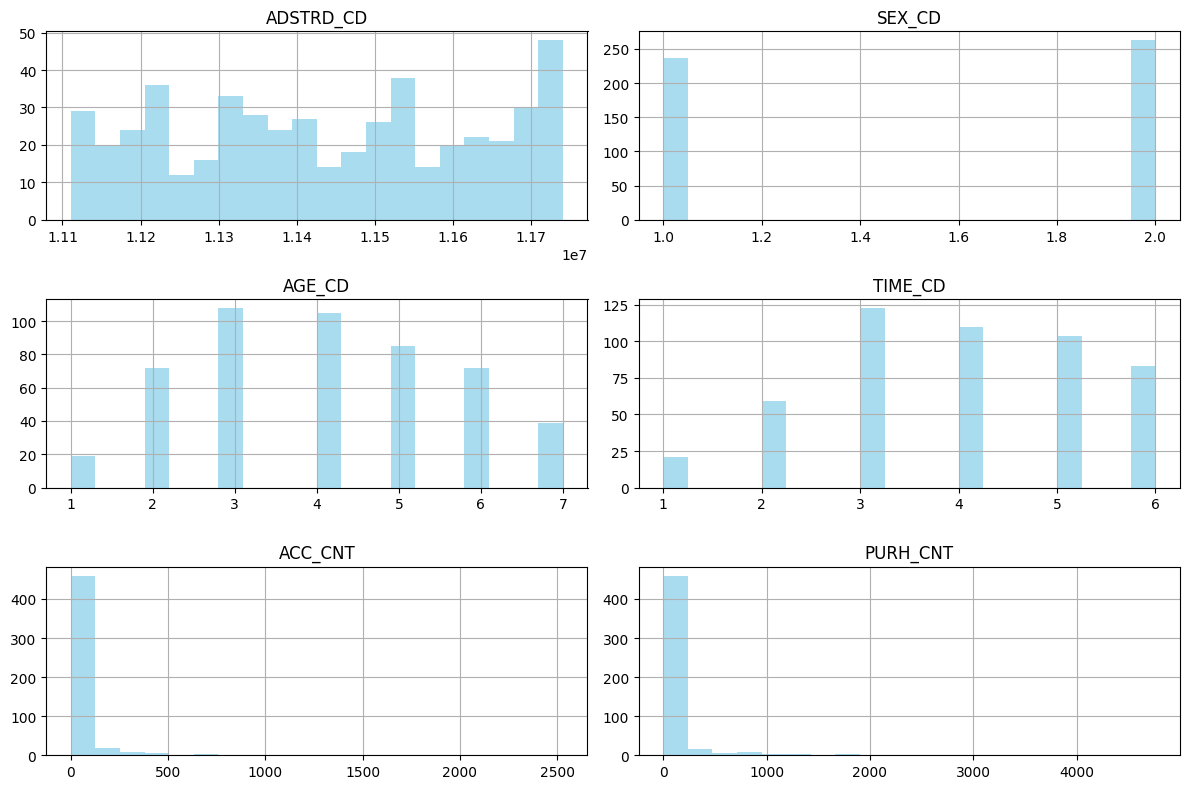

In [29]:
pandas_df.hist(bins=20, figsize=(12, 8), color='skyblue', alpha=0.7)
plt.tight_layout()
plt.show()

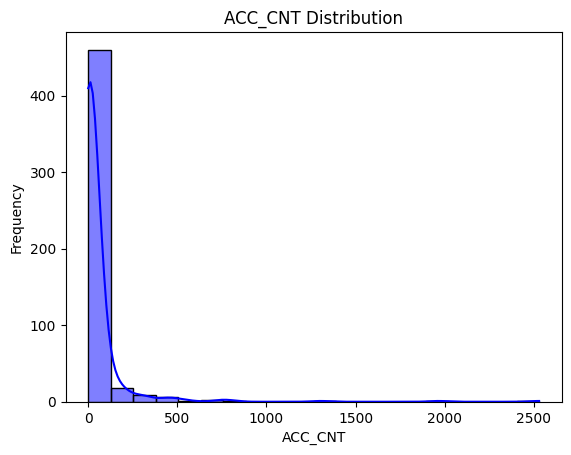

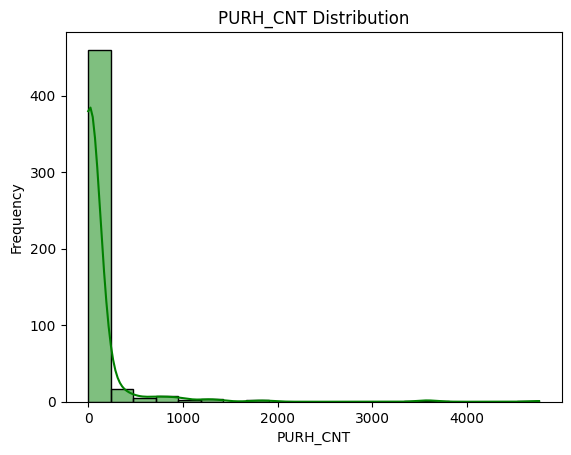

In [30]:
import seaborn as sns

# ACC_CNT 히스토그램
sns.histplot(data=pandas_df, x="ACC_CNT", bins=20, kde=True, color='blue')
plt.title("ACC_CNT Distribution")
plt.xlabel("ACC_CNT")
plt.ylabel("Frequency")
plt.show()

# PURH_CNT 히스토그램
sns.histplot(data=pandas_df, x="PURH_CNT", bins=20, kde=True, color='green')
plt.title("PURH_CNT Distribution")
plt.xlabel("PURH_CNT")
plt.ylabel("Frequency")
plt.show()


### 3) 상관관계 분석

In [92]:
# Pandas로 상관계수 계산
numeric_data = pandas_df.select_dtypes(include="number")  # 숫자형 데이터만 선택
correlation_matrix = numeric_data.corr()

# 결과 확인
print(correlation_matrix)

           ADSTRD_CD    SEX_CD    AGE_CD   TIME_CD   ACC_CNT  PURH_CNT
ADSTRD_CD   1.000000  0.003275  0.023453  0.068500  0.011732  0.077698
SEX_CD      0.003275  1.000000  0.073708 -0.020341 -0.027814 -0.049088
AGE_CD      0.023453  0.073708  1.000000  0.040474 -0.054096 -0.012006
TIME_CD     0.068500 -0.020341  0.040474  1.000000 -0.034616 -0.028658
ACC_CNT     0.011732 -0.027814 -0.054096 -0.034616  1.000000  0.016441
PURH_CNT    0.077698 -0.049088 -0.012006 -0.028658  0.016441  1.000000


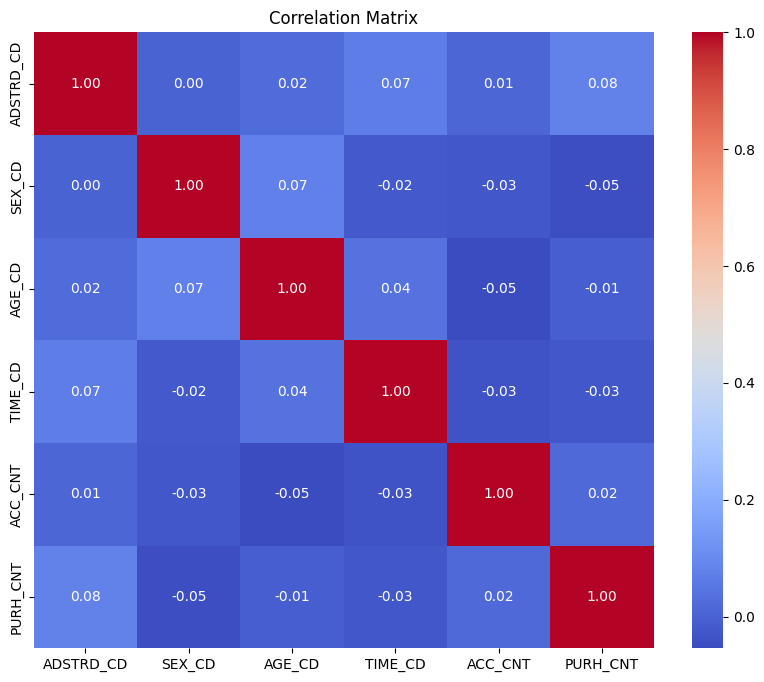

In [93]:
import seaborn as sns
import matplotlib.pyplot as plt

# 상관계수 계산
correlation_matrix = numeric_data.corr()

# 히트맵 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()


## 4. 모델 구축

### 1) 피쳐 선택 및 변환

In [31]:
from pyspark.ml.feature import StringIndexer

# 범주형 데이터 컬럼 리스트
category = ["ADSTRD_CD", "STAT_CD", "SEX_CD", "AGE_CD", "TIME_CD"]

# StringIndexer를 단계별로 생성
indexers = [
    StringIndexer(inputCol=col, outputCol=col + "_Index", handleInvalid="keep") 
    for col in category
]



### 2) 피처 벡터 어셈블

In [32]:
from pyspark.ml.feature import StringIndexer, VectorAssembler

# VectorAssembler 설정
assembler = VectorAssembler(
    inputCols=[col + "_Index" for col in category],
    outputCol="features"
)

### 3) 파이프라인 설정

In [33]:
from pyspark.ml import Pipeline

# 파이프라인 설정
pipeline = Pipeline(stages=indexers + [assembler])

# 파이프라인 실행
pipeline_model = pipeline.fit(a_df)
df_transformed = pipeline_model.transform(a_df)

# 결과 확인
df_transformed.select("features", "ACC_CNT").show()

+--------------------+-------+
|            features|ACC_CNT|
+--------------------+-------+
|[160.0,1.0,1.0,1....|      5|
|[55.0,1.0,1.0,5.0...|    179|
|[90.0,5.0,0.0,0.0...|      5|
|[66.0,2.0,1.0,4.0...|    331|
|[55.0,2.0,1.0,4.0...|      9|
|[86.0,3.0,0.0,5.0...|     18|
|[115.0,0.0,0.0,4....|      1|
|[70.0,0.0,1.0,1.0...|      3|
|[36.0,1.0,0.0,0.0...|      3|
|[34.0,1.0,1.0,1.0...|      3|
|[252.0,3.0,1.0,1....|      2|
|[59.0,2.0,1.0,0.0...|      7|
|[52.0,8.0,0.0,5.0...|     10|
|[103.0,2.0,1.0,2....|     59|
|[145.0,3.0,1.0,2....|      1|
| (5,[0,2],[9.0,1.0])|      3|
|[139.0,6.0,0.0,5....|      1|
|[93.0,3.0,1.0,2.0...|      1|
|[5.0,4.0,1.0,1.0,...|     15|
|[80.0,1.0,1.0,0.0...|    288|
+--------------------+-------+
only showing top 20 rows



### 4) 데이터 분할

In [34]:
train_data, test_data = df_transformed.randomSplit([0.8, 0.2], seed=42)

In [35]:
train_data.show(5), test_data.show(5)

+------+---------+-------+------+------+-------+-------+--------+---------------+-------------+------------+------------+-------------+--------------------+
|STD_YM|ADSTRD_CD|STAT_CD|SEX_CD|AGE_CD|TIME_CD|ACC_CNT|PURH_CNT|ADSTRD_CD_Index|STAT_CD_Index|SEX_CD_Index|AGE_CD_Index|TIME_CD_Index|            features|
+------+---------+-------+------+------+-------+-------+--------+---------------+-------------+------------+------------+-------------+--------------------+
|201801| 11230660|      I|     2|     2|      2|      7|     951|          172.0|          4.0|         0.0|         3.0|          4.0|[172.0,4.0,0.0,3....|
|201801| 11260570|      J|     2|     4|      3|      1|      21|          179.0|          5.0|         0.0|         1.0|          0.0|[179.0,5.0,0.0,1....|
|201801| 11380552|      B|     2|     4|      5|     10|       2|            7.0|          2.0|         0.0|         1.0|          2.0|[7.0,2.0,0.0,1.0,...|
|201801| 11410565|      B|     1|     6|      3|      8|  

(None, None)

### 5) 모델 학습(Linear Regression)

In [36]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(featuresCol="features", labelCol="ACC_CNT")
lr_model = lr.fit(train_data)

24/12/20 09:38:59 WARN Instrumentation: [3cee3c50] regParam is zero, which might cause numerical instability and overfitting.
24/12/20 09:38:59 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
24/12/20 09:38:59 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS
24/12/20 09:38:59 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
24/12/20 09:38:59 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK


In [37]:
predictions = lr_model.transform(test_data)

## 4. 데이터 분석

### 1) 행정구역 별 구매 예측

#### 1.1) 예측값 확인

In [38]:
predictions.select("ADSTRD_CD", "prediction").orderBy("prediction", ascending=False).show(10)

+---------+------------------+
|ADSTRD_CD|        prediction|
+---------+------------------+
| 11170510| 53.72945716864818|
| 11170570| 52.45293851525186|
| 11110650| 52.29423365193712|
| 11410555|51.419078324371725|
| 11545640| 51.34048648809655|
| 11350720| 51.26484023161154|
| 11650610|50.680037865583444|
| 11440710| 50.45847037246713|
| 11500560|50.304232279706945|
| 11500530| 49.87579805293862|
+---------+------------------+
only showing top 10 rows



#### 1.2) 실제 데이터 확인

In [39]:
# 예측값과 실제값 비교
predictions.select("ADSTRD_CD", "ACC_CNT", "prediction").orderBy("prediction", ascending=False).show(15)

+---------+-------+------------------+
|ADSTRD_CD|ACC_CNT|        prediction|
+---------+-------+------------------+
| 11170510|     12| 53.72945716864818|
| 11170570|      3| 52.45293851525186|
| 11110650|      1| 52.29423365193712|
| 11410555|      9|51.419078324371725|
| 11545640|     49| 51.34048648809655|
| 11350720|     27| 51.26484023161154|
| 11650610|      2|50.680037865583444|
| 11440710|      5| 50.45847037246713|
| 11500560|      7|50.304232279706945|
| 11500530|    173| 49.87579805293862|
| 11440680|    305|49.824936133818134|
| 11560620|     34| 49.75321863463021|
| 11680730|     46| 49.47168631146045|
| 11200615|      2| 49.36758451527288|
| 11620685|      6| 49.24047551371363|
+---------+-------+------------------+
only showing top 15 rows



### 1.3) 모델 성능 평가

In [40]:
from pyspark.ml.evaluation import RegressionEvaluator

# RMSE 계산
rmse_evaluator = RegressionEvaluator(
    labelCol="ACC_CNT", predictionCol="prediction", metricName="rmse"
)
rmse = rmse_evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# R² 계산
r2_evaluator = RegressionEvaluator(
    labelCol="ACC_CNT", predictionCol="prediction", metricName="r2"
)
r2 = r2_evaluator.evaluate(predictions)
print(f"R-Squared (R²): {r2}")

Root Mean Squared Error (RMSE): 278.7591192400323
R-Squared (R²): -0.013564485955329886


- 실제 데이터 예측을 잘 하지 못하며, 모델 성능 평가 시에도 모델의 성능이 나쁜 것으로 나타남. 

### 1.4) 데이터 시각화

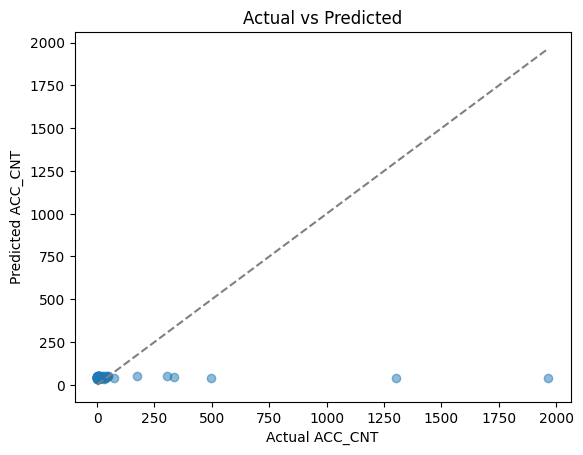

In [41]:
import matplotlib.pyplot as plt
import pandas as pd


pd_df = predictions.select("ACC_CNT", "prediction").toPandas()

# 예측값 vs 실제값
plt.scatter(pd_df["ACC_CNT"], pd_df["prediction"], alpha=0.5)
plt.plot([0, max(pd_df["ACC_CNT"])], [0, max(pd_df["ACC_CNT"])], color='grey', linestyle='--')
plt.xlabel("Actual ACC_CNT")
plt.ylabel("Predicted ACC_CNT")
plt.title("Actual vs Predicted")
plt.show()


### 2. 시간대별 구매 예측

In [42]:
# VectorAssembler로 피처 생성
assembler = VectorAssembler(
    inputCols=["TIME_CD"],  # 모델 입력 피처
    outputCol="features"
)
time_df = assembler.transform(a_df)

# 데이터 분할
train_df, test_df = time_df.randomSplit([0.8, 0.2], seed=42)

# 모델 정의 및 학습
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(featuresCol="features", labelCol="ACC_CNT")  # 타깃 변수는 ACC_CNT
lr_model = lr.fit(train_df)

# 예측 수행
predictions = lr_model.transform(test_df)

# 결과 확인
predictions.select("TIME_CD", "ACC_CNT", "prediction").show()


24/12/20 09:39:30 WARN Instrumentation: [c5569c8e] regParam is zero, which might cause numerical instability and overfitting.


+-------+-------+------------------+
|TIME_CD|ACC_CNT|        prediction|
+-------+-------+------------------+
|      5|     27| 35.77159023574112|
|      4|    305| 44.33172803216024|
|      5|     24| 35.77159023574112|
|      3|      1| 52.89186582857936|
|      3|      2| 52.89186582857936|
|      4|      2| 44.33172803216024|
|      1|     13|  70.0121414214176|
|      6|     30|27.211452439322002|
|      5|      5| 35.77159023574112|
|      2|      2| 61.45200362499848|
|      3|      1| 52.89186582857936|
|      6|     12|27.211452439322002|
|      3|      1| 52.89186582857936|
|      5|      7| 35.77159023574112|
|      4|     20| 44.33172803216024|
|      2|      5| 61.45200362499848|
|      4|     17| 44.33172803216024|
|      5|      3| 35.77159023574112|
|      3|      1| 52.89186582857936|
|      3|      1| 52.89186582857936|
+-------+-------+------------------+
only showing top 20 rows



In [43]:
from pyspark.ml.evaluation import RegressionEvaluator

# RMSE 계산
rmse_evaluator = RegressionEvaluator(labelCol="ACC_CNT", predictionCol="prediction", metricName="rmse")
rmse = rmse_evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# R² 계산
r2_evaluator = RegressionEvaluator(labelCol="ACC_CNT", predictionCol="prediction", metricName="r2")
r2 = r2_evaluator.evaluate(predictions)
print(f"R-Squared (R²): {r2}")

Root Mean Squared Error (RMSE): 279.6726659613162
R-Squared (R²): -0.020218659306897147


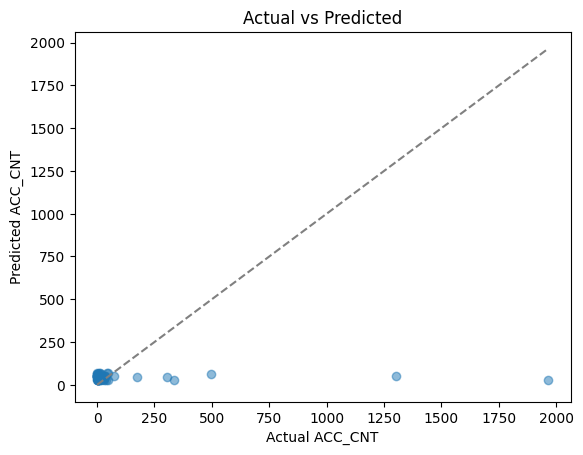

In [45]:
pd_df = predictions.select("ACC_CNT", "prediction").toPandas()

# 예측값 vs 실제값
plt.scatter(pd_df["ACC_CNT"], pd_df["prediction"], alpha=0.5)
plt.plot([0, max(pd_df["ACC_CNT"])], [0, max(pd_df["ACC_CNT"])], color='grey', linestyle='--')
plt.xlabel("Actual ACC_CNT")
plt.ylabel("Predicted ACC_CNT")
plt.title("Actual vs Predicted")
plt.show()

### 3) 기준연월에 따른 소비 예측

In [46]:
b_df = df.select("STD_YM", "ADSTRD_CD", "STAT_CD", "SEX_CD", "AGE_CD", "TIME_CD", "PURH_CNT", "PURH_AMT")

In [47]:
b_df.describe().show()

+-------+------------------+------------------+-------+-------------------+------------------+------------------+-----------------+-----------------+
|summary|            STD_YM|         ADSTRD_CD|STAT_CD|             SEX_CD|            AGE_CD|           TIME_CD|         PURH_CNT|         PURH_AMT|
+-------+------------------+------------------+-------+-------------------+------------------+------------------+-----------------+-----------------+
|  count|               500|               500|    500|                500|               500|               500|              500|              500|
|   mean|        201853.004|    1.1435948382E7|   null|              1.526|             4.074|             3.932|            99.12|         722868.0|
| stddev|50.132329738103536|185625.45644591315|   null|0.49982361618333826|1.6067630113832891|1.4026085060495268|373.8095514583904|3561238.085269778|
|    min|            201801|          11110530|      A|                  1|                 1|      

In [49]:
b_df.groupBy("STD_YM").count().orderBy("count", ascending=False).show()
b_df.groupBy("STD_YM").count().orderBy("count", ascending=False).count()

+------+-----+
|STD_YM|count|
+------+-----+
|201803|   32|
|201810|   29|
|201802|   26|
|201805|   25|
|201907|   23|
|201812|   23|
|201908|   23|
|201910|   22|
|201904|   21|
|201806|   21|
|201901|   21|
|201801|   21|
|201905|   20|
|201808|   20|
|201809|   20|
|201909|   19|
|201906|   19|
|201804|   18|
|201902|   18|
|201811|   17|
+------+-----+
only showing top 20 rows



24

In [57]:
# STD_YM별 데이터 합산
std_ym_df = b_df.groupBy("STD_YM").agg(
    {"PURH_AMT": "sum"}
).withColumnRenamed("sum(PURH_AMT)", "PURH_AMT_SUM")

# 결과 확인
std_ym_df.show()

+------+------------+
|STD_YM|PURH_AMT_SUM|
+------+------------+
|201805|     9453000|
|201905|    25810000|
|201910|    19267000|
|201909|    18972000|
|201802|    24765000|
|201809|     6924000|
|201912|     2759000|
|201906|     3723000|
|201902|    72167000|
|201806|     5246000|
|201812|     4861000|
|201901|     4848000|
|201908|     6885000|
|201801|    12299000|
|201808|     7877000|
|201807|     7963000|
|201904|     7458000|
|201810|    48003000|
|201804|    21874000|
|201811|     7579000|
+------+------------+
only showing top 20 rows



In [58]:
from pyspark.ml.feature import StringIndexer, VectorAssembler

# STD_YM 인코딩
indexer = StringIndexer(inputCol="STD_YM", outputCol="STD_YM_Index")
std_ym_df = indexer.fit(std_ym_df).transform(std_ym_df)

In [59]:
# VectorAssembler로 피처 생성
assembler = VectorAssembler(
    inputCols=["STD_YM_Index"],  # 입력 피처
    outputCol="features"
)
std_ym_df = assembler.transform(std_ym_df)

In [60]:
# 데이터 분할
train_df, test_df = std_ym_df.randomSplit([0.8, 0.2], seed=42)
train_df.show(3)
test_df.show(3)

+------+------------+------------+--------+
|STD_YM|PURH_AMT_SUM|STD_YM_Index|features|
+------+------------+------------+--------+
|201805|     9453000|         4.0|   [4.0]|
|201905|    25810000|        16.0|  [16.0]|
|201910|    19267000|        21.0|  [21.0]|
+------+------------+------------+--------+
only showing top 3 rows



+------+------------+------------+--------+
|STD_YM|PURH_AMT_SUM|STD_YM_Index|features|
+------+------------+------------+--------+
|201912|     2759000|        23.0|  [23.0]|
|201811|     7579000|        10.0|  [10.0]|
|201907|    10931000|        18.0|  [18.0]|
+------+------------+------------+--------+



In [61]:
from pyspark.ml.regression import LinearRegression

# 모델 정의 및 학습
lr = LinearRegression(featuresCol="features", labelCol="PURH_AMT_SUM")
lr_model = lr.fit(train_df)

# 예측 수행
predictions = lr_model.transform(test_df)

# 결과 확인
predictions.select("STD_YM", "STD_YM_Index", "PURH_AMT_SUM", "prediction").show()


24/12/20 11:17:09 WARN Instrumentation: [e3a4cb63] regParam is zero, which might cause numerical instability and overfitting.
                                                                                

+------+------------+--------------------+
|STD_YM|PURH_AMT_SUM|          prediction|
+------+------------+--------------------+
|201912|     2759000| 1.474287097094118E7|
|201811|     7579000|1.6282953238123577E7|
|201907|    10931000|1.5335210304472871E7|
+------+------------+--------------------+



In [62]:
from pyspark.ml.evaluation import RegressionEvaluator

# RMSE 계산
rmse_evaluator = RegressionEvaluator(labelCol="PURH_AMT_SUM", predictionCol="prediction", metricName="rmse")
rmse = rmse_evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# R² 계산
r2_evaluator = RegressionEvaluator(labelCol="PURH_AMT_SUM", predictionCol="prediction", metricName="r2")
r2 = r2_evaluator.evaluate(predictions)
print(f"R-Squared (R²): {r2}")


[Stage 177:================================================>    (184 + 2) / 200]

Root Mean Squared Error (RMSE): 8921304.72194947


[Stage 180:===============================================>     (178 + 3) / 200]

R-Squared (R²): -6.074645865059139


### 4) 다중 피처 입력을 통한 소비 예측

In [63]:
c_df = df.select("STD_YM", "ADSTRD_CD", "SEX_CD", "AGE_CD", "TIME_CD", "PURH_CNT", "ACC_CNT")

In [78]:
from pyspark.ml.feature import StringIndexer

# 범주형 데이터 인코딩
indexers = [
    StringIndexer(inputCol=col, outputCol=col + "_Index") 
    for col in ["STD_YM", "ADSTRD_CD", "SEX_CD", "AGE_CD", "TIME_CD"]
]

In [79]:
from pyspark.ml.feature import VectorAssembler

input_features = ["STD_YM_Index", "ADSTRD_CD_Index", "SEX_CD_Index", "AGE_CD_Index", "TIME_CD_Index", "PURH_CNT"]
assembler = VectorAssembler(inputCols=input_features, outputCol="features")
c_df = assembler.transform(c_df)

In [80]:
# 데이터 분할
train_df, test_df = c_df.randomSplit([0.8, 0.2], seed=42)

In [81]:
print(train_df.columns)

['STD_YM', 'ADSTRD_CD', 'SEX_CD', 'AGE_CD', 'TIME_CD', 'PURH_CNT', 'ACC_CNT', 'STD_YM_Index', 'ADSTRD_CD_Index', 'SEX_CD_Index', 'AGE_CD_Index', 'TIME_CD_Index', 'features']


In [85]:
from pyspark.ml.regression import LinearRegression

# Linear Regression 모델 설정
lr = LinearRegression(featuresCol="features", labelCol="ACC_CNT", regParam=0.1, elasticNetParam=0.5)

# 모델 학습
lr_model = lr.fit(train_df)

In [86]:
# 예측 수행
predictions = lr_model.transform(test_df)

# 결과 확인
predictions.select("STD_YM", "ADSTRD_CD", "ACC_CNT", "prediction").show(10)


+------+---------+-------+------------------+
|STD_YM|ADSTRD_CD|ACC_CNT|        prediction|
+------+---------+-------+------------------+
|201801| 11350720|     27|47.831726988871864|
|201801| 11440680|    305| 43.34026623552272|
|201801| 11470570|     24| 45.18766637804431|
|201801| 11620625|      1|40.654947424656015|
|201801| 11740540|      2|  53.7554498383928|
|201802| 11200615|      2|39.352534376014816|
|201802| 11320512|     13| 34.56807939611056|
|201802| 11380580|     30| 37.03300840500275|
|201802| 11710600|      5|  38.4066226541641|
|201802| 11710642|      2|37.262301066279775|
+------+---------+-------+------------------+
only showing top 10 rows



In [87]:
from pyspark.ml.evaluation import RegressionEvaluator

# RMSE 계산
rmse_evaluator = RegressionEvaluator(labelCol="ACC_CNT", predictionCol="prediction", metricName="rmse")
rmse = rmse_evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# R² 계산
r2_evaluator = RegressionEvaluator(labelCol="ACC_CNT", predictionCol="prediction", metricName="r2")
r2 = r2_evaluator.evaluate(predictions)
print(f"R-Squared (R²): {r2}")

Root Mean Squared Error (RMSE): 279.498024386074
R-Squared (R²): -0.018252849014983363


### 추후 분석 방향 제시
1) 기준연월별 분석 > 원데이터(숫자)인 상태로 다시 분석
2) count를 feature에 추가해서 학습

   
4) 행정구역별 구매 > 행정구역별 구매자수or금액 sum한 후 다시 예측